# ANALITICA DE DATOS CON INTELIGENCIA ARTIFICIAL

# EDA con datos EPM

**Universidad de los Andes**

2024

---

Juan C. Vega MsC

# PREDICCION DE ENSA A PARTIR DE DEEP LEARNING para EL MES DE MAYO

**Necesidad:** modelar la relación existente entre el registro de temperatura de las instalaciones (puntos de servicio) del Área Metropolitana de Medellín de acuerdo con tomas de drones termográficos (por realizar) y el consumo de energía de las instalaciones, así como el registro histórico de defraudaciones de dicho servicio (fraudes).

In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Montar Google Drive (asumiendo que los datos están allí)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar los datos
file_path = '/content/drive/MyDrive/Colab Notebooks/DIPLOMADO EPM/Git/BD_maestro.csv'  # Ajusta a la ubicación de tu archivo CSV
datos_Maestro = pd.read_csv(file_path)

In [ ]:
# Convertir la columna 'fecha' a datetime
datos_Maestro['fecha'] = pd.to_datetime(datos_Maestro['fecha'])

In [ ]:
datos_Maestro.describe()

,fecha,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA,dummy
count,168,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.0
mean,2016-12-15 16:17:08.571428608,-0.042262,41.325214,0.056429,55.482143,0.085714,71.732143,3.432738,806.142857,283.601190,0.0
min,2010-01-01 00:00:00,-1.700000,25.066000,-0.180000,29.440000,-0.180000,17.000000,1.600000,529.000000,195.000000,0.0
25%,2013-06-23 12:00:00,-0.700000,32.745000,0.050000,45.600000,0.070000,52.000000,2.600000,706.750000,254.750000,0.0
50%,2016-12-16 12:00:00,-0.200000,37.277000,0.060000,55.964000,0.090000,72.000000,3.000000,827.500000,289.000000,0.0
75%,2020-06-08 12:00:00,0.500000,41.799000,0.100000,64.929000,0.140000,89.750000,4.100000,894.000000,312.000000,0.0
max,2023-12-01 00:00:00,2.600000,78.591000,0.160000,76.523000,0.180000,115.000000,8.800000,1067.000000,361.000000,0.0
std,NaN,0.903917,15.107150,0.073764,13.913906,0.087003,22.023252,1.273004,123.033382,38.216393,0.0


In [ ]:
# Encontrar NaNs y valores duplicados en datos_Maestro

print('hay {} valores missing o NaNs en datos_Maestro.'
      .format(datos_Maestro.isnull().values.sum()))

temp_datos = datos_Maestro.duplicated(keep='first').sum()

print('hay {} filas duplicadas en datos_Maestro revisando todas las columnas.'
      .format(temp_datos))

hay 0 valores missing o NaNs en datos_Maestro.
hay 0 filas duplicadas en datos_Maestro revisando todas las columnas.


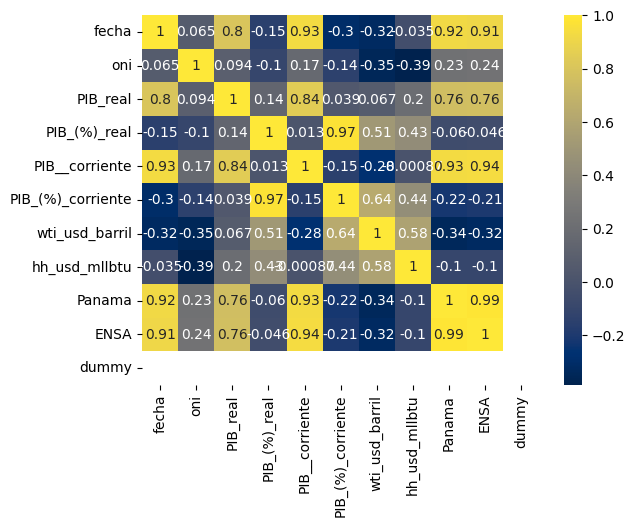

In [ ]:
# EDA básico: matriz de correlación y gráficas
sns.heatmap(datos_Maestro.corr(), annot=True, cmap='cividis')
plt.show()

In [ ]:

correlations = datos_Maestro.corr(method='pearson')
print(correlations['ENSA'].sort_values(ascending=False).to_string())

ENSA                 1.000000
Panama               0.986787
PIB__corriente       0.939072
fecha                0.909834
PIB_real             0.764443
oni                  0.239502
PIB_(%)_real        -0.045753
hh_usd_mllbtu       -0.103195
PIB_(%)_corriente   -0.206166
wti_usd_barril      -0.324960
dummy                     NaN


In [ ]:
datos_Maestro.dtypes

fecha                datetime64[ns]
oni                         float64
PIB_real                    float64
PIB_(%)_real                float64
PIB__corriente              float64
PIB_(%)_corriente           float64
wti_usd_barril                int64
hh_usd_mllbtu               float64
Panama                        int64
ENSA                          int64
dummy                         int64
dtype: object

#Graficos para analisis visual exploratorio

In [ ]:
# Definir una funcion para graficar los diferentes tipos de time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):

    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

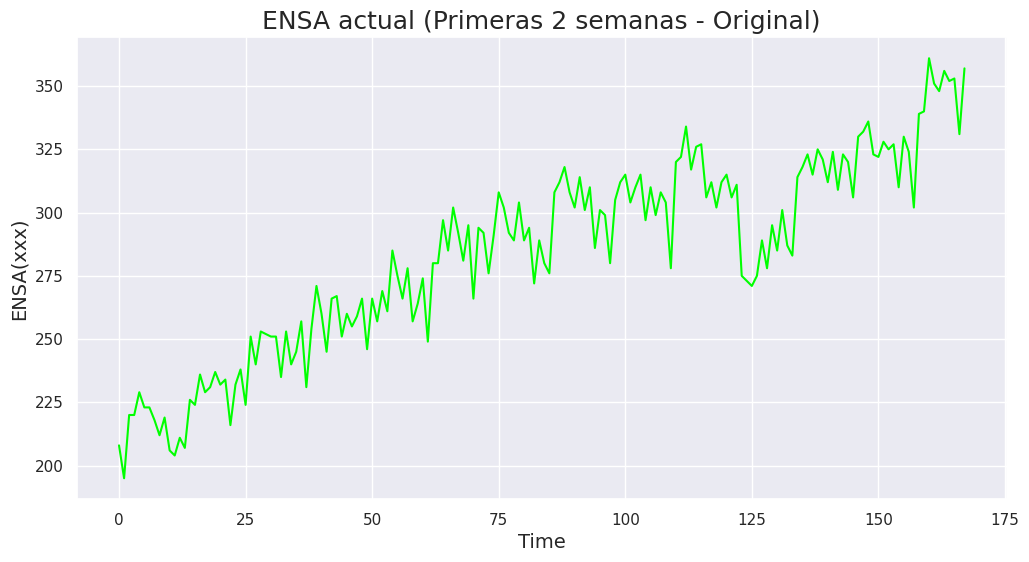

In [ ]:
ax = plot_series(df=datos_Maestro, column='ENSA', ylabel='ENSA(xxx)',
                 title='ENSA actual (Primeras 2 semanas - Original)', end=24*7*2)
plt.show()

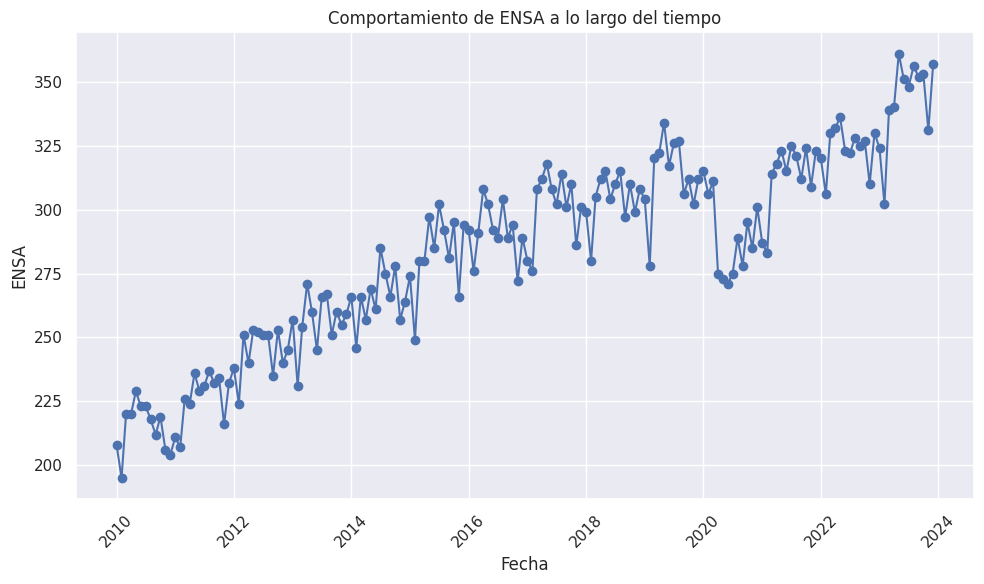

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#muestras_fechas = datos_Maestro['fecha'].sample(n=10)  # Cambia 'n' al número deseado de muestras


# Graficar
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Graficar la línea
plt.plot(datos_Maestro['fecha'], datos_Maestro['ENSA'], marker='o', linestyle='-')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('ENSA')
plt.title('Comportamiento de ENSA a lo largo del tiempo')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar todas las divisiones de fecha en el eje x
#plt.xticks(muestras_fechas)

# Mostrar la cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el diseño para evitar recortes
plt.show()

Se crea grafico de barras para entender la distribucion de la variable ENSA

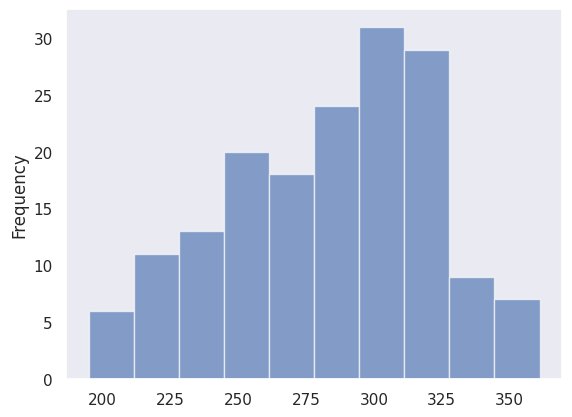

In [ ]:
# Grafiquemos el histograma del precio actual de la electricidad

ax = datos_Maestro['ENSA'].plot.hist(bins=10, alpha=0.65)

In [ ]:
# Borrar columnas con informacion metereologica cualitativa
datos_Maestro = datos_Maestro.drop(['dummy'], axis=1)

In [ ]:
datos_Maestro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha              168 non-null    datetime64[ns]
 1   oni                168 non-null    float64       
 2   PIB_real           168 non-null    float64       
 3   PIB_(%)_real       168 non-null    float64       
 4   PIB__corriente     168 non-null    float64       
 5   PIB_(%)_corriente  168 non-null    float64       
 6   wti_usd_barril     168 non-null    int64         
 7   hh_usd_mllbtu      168 non-null    float64       
 8   Panama             168 non-null    int64         
 9   ENSA               168 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 13.2 KB


# Preparacion de los datos

Se aplica estandarizacion y escalado de los datos para preparacion al momento de hacer entramiento de modelo LSTM

In [ ]:
# Estandarización de los datos

# Seleccionar solo columnas numéricas
datos_numericos = datos_Maestro.select_dtypes(include=[np.number])

# Estandarización de los datos numéricos
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(datos_numericos)
datos_escalados = pd.DataFrame(datos_escalados, columns=datos_numericos.columns)

# Añadir de nuevo las columnas no numéricas al DataFrame escalado
for col in datos_Maestro.select_dtypes(exclude=[np.number]).columns:
    datos_escalados[col] = datos_Maestro[col]


In [ ]:
datos_numericos.info()
#df = pd.DataFrame(datos_numericos)
#datos_Maestro.to_csv('/content/drive/MyDrive/Colab Notebooks/DIPLOMADO EPM/Git/DF2.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   oni                168 non-null    float64
 1   PIB_real           168 non-null    float64
 2   PIB_(%)_real       168 non-null    float64
 3   PIB__corriente     168 non-null    float64
 4   PIB_(%)_corriente  168 non-null    float64
 5   wti_usd_barril     168 non-null    int64  
 6   hh_usd_mllbtu      168 non-null    float64
 7   Panama             168 non-null    int64  
 8   ENSA               168 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 11.9 KB


El codigo incialmente tenia un error, y era que no se estaban tomando los datos escalados para el modelo, sino los datos en forma numerico total, esto generaba problemas en la prediccion del modelo, lo que se hace entonecs es usar loos datos escalados y en la siguiente linea se hace un ajuste para indexar la fecha y visualizar de forma ordenada los datos escalados.

In [ ]:
datos_escalados_sort =  datos_escalados.sort_values(by='fecha').copy()
datos_escalados_sort = datos_escalados_sort.set_index('fecha').copy()
datos_escalados_sort

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA
fecha,,,,,,,,,
2010-01-01,1.711300,-1.079477,0.048562,-1.877258,0.049407,0.285453,1.865147,-1.933230,-1.984154
2010-02-01,1.489379,-1.079477,0.048562,-1.877258,0.049407,0.194368,1.471201,-2.259317,-2.325339
2010-03-01,1.045537,-1.079477,0.048562,-1.877258,0.049407,0.422080,0.683309,-1.484860,-1.669214
2010-04-01,0.490736,-1.079477,0.048562,-1.877258,0.049407,0.558706,0.446941,-1.664208,-1.669214
2010-05-01,-0.064066,-1.079477,0.048562,-1.877258,0.049407,0.103283,0.525730,-1.484860,-1.433009
...,...,...,...,...,...,...,...,...,...
2023-08-01,1.489379,2.474139,0.184536,1.516739,0.049407,0.422080,-0.656108,1.857531,1.900107
2023-09-01,1.822260,2.474139,0.184536,1.516739,0.049407,0.786418,-0.656108,1.564053,1.795127
2023-10-01,2.044181,2.474139,0.184536,1.516739,0.049407,0.649791,-0.340951,1.824922,1.821372


In [ ]:
# Preparar datos para LSTM
window_size = 24
X = []
y = []

for i in range(window_size, len(datos_escalados_sort) - 12):  # -12 para predecir el año completo de 2024
    X.append(datos_escalados_sort.iloc[i-window_size:i, :-1].values)  # Todas las variables excepto ENSA
    y.append(datos_escalados_sort.iloc[i, -1])  # La variable ENSA

X, y = np.array(X), np.array(y)

In [ ]:
# División en entrenamiento y validación
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

Antes de entrar al modelo se realizar una analisis exploratorio de datos usando PCA para validar relevancia de los diferentes atributos/variables en cuanto a la variable a predecir "ENSA".

In [ ]:
#PCA
from sklearn.decomposition import PCA
X_train = np.reshape(X_train, (X_train.shape[0], -1))

pca = PCA()
X_pca = pca.fit_transform(X_train[:train_size])

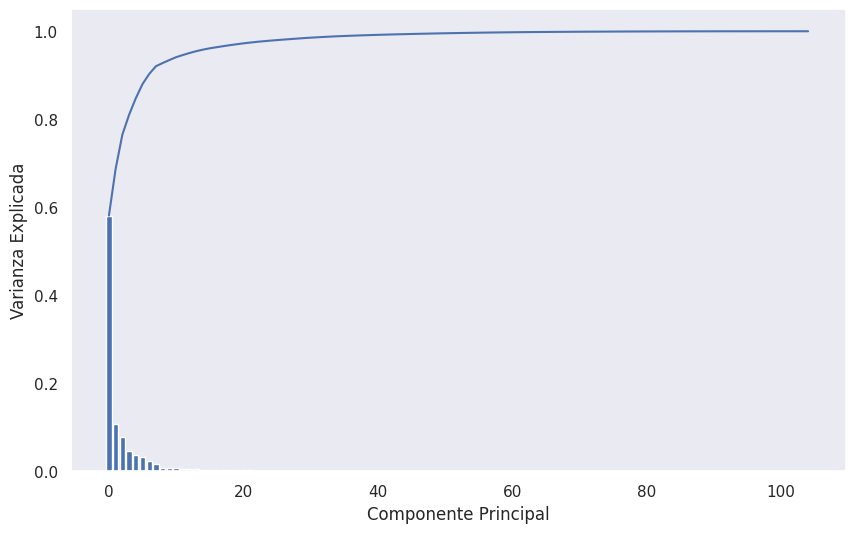

In [ ]:
num_components = len(pca.explained_variance_ratio_) #almacena el número total de componentes principales generados por el modelo PCA
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.show()

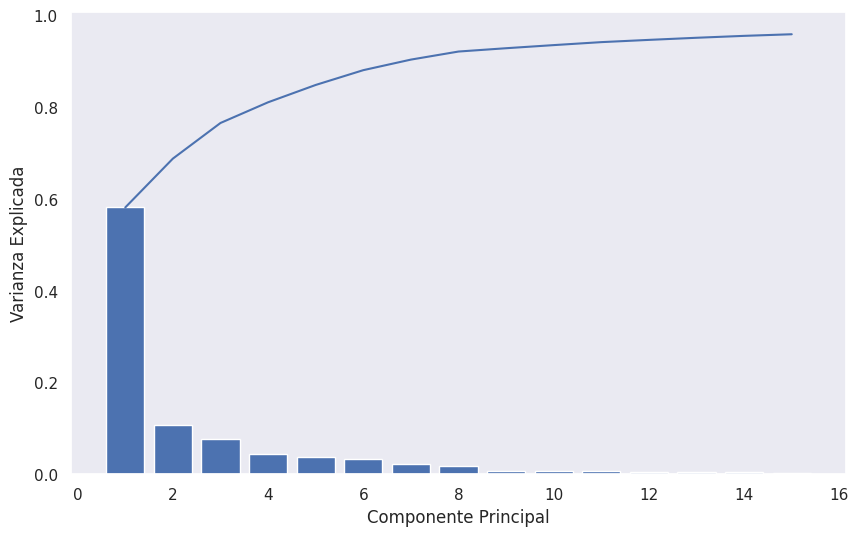

In [ ]:
num_components = len(pca.explained_variance_ratio_) # Número total de componentes principales generados por el modelo PCA
componentes = np.arange(1, num_components + 1) # Componentes principales de 1 a num_components

plt.figure(figsize=(10, 6))
plt.bar(componentes[:15], pca.explained_variance_ratio_[:15]) # Limita la visualización hasta el componente 15
plt.plot(componentes[:15], np.cumsum(pca.explained_variance_ratio_[:15]))
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.show()

# Arquitectura LSTM

In [ ]:
# Definir la arquitectura LSTM
model = Sequential([
    #InputLayer((window_size, datos_numericos.shape[1] - 1)),
    InputLayer((window_size, datos_escalados_sort.shape[1] - 1)),
    LSTM(64, activation='relu'),
    Dense(8, activation='tanh'),
    Dense(1, activation='linear')
])

In [ ]:
# Guardar la visualización del modelo
plot_model(model1, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Definir la arquitectura GRU
#model = Sequential([
    #InputLayer(input_shape=(window_size, datos_numericos.shape[1] - 1)),
    #GRU(50, activation='relu', return_sequences=True),
    #GRU(50, activation='relu'),
    #Dense(20, activation='relu'),
    #Dense(1)
#])

In [ ]:
# Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
4/4 [==============================] - 2s 146ms/step - loss: 0.2855 - val_loss: 1.1914
Epoch 2/100
4/4 [==============================] - 0s 36ms/step - loss: 0.1363 - val_loss: 0.8506
Epoch 3/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0963 - val_loss: 0.5666
Epoch 4/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0934 - val_loss: 0.3677
Epoch 5/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0886 - val_loss: 0.3288
Epoch 6/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0833 - val_loss: 0.3827
Epoch 7/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0823 - val_loss: 0.5191
Epoch 8/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0807 - val_loss: 0.5247
Epoch 9/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0783 - val_loss: 0.4181
Epoch 10/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0777 - val_loss: 0.4076
Epoch 11/100
4/4 [

In [ ]:
###**MODELO:** Optimizar LSTM

In [ ]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM, Dense, RNN, GRU
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import SVG

!pip install keras-tuner
import keras_tuner as kt

from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
# Define un objeto HyperParameters
hp = HyperParameters()

In [ ]:
input_shape = X_train.shape[-2:]  # Toma las últimas dos dimensiones de X_train para definir la forma de entrada del modelo.


In [ ]:
def build_lstm_model(hp):
    #n_timesteps, n_features = X_train.shape[1], X_train.shape[2] # ELEGIR LOS HIPERPARAMETROS QUE NECESITEN OPTIMIZAR
    #n_outputs = 1  # Cambia esto si el número de salidas es diferente
    #n_layers = hp.Int('n_layers', min_value=1, max_value=10)

    modelop = Sequential()
    modelop.add(InputLayer((window_size, 17))) # Cual es el tamano de los datos de entrada


    modelop.add(LSTM(
        units=hp.Int('lstm_units', min_value=1, max_value=200, step=10),  # Número de unidades en la capa LSTM, ajustable entre 32 y 128 en pasos de 32
        input_shape=input_shape,  # La forma de los datos de entrada (debe ser definida antes de llamar a esta función)
        activation=hp.Choice('l_lstm_activation', values=['tanh', 'relu', 'sigmoid']),
        return_sequences=False  # Indica que esta capa LSTM devolverá solo la última salida en la secuencia de salida
    ))

    modelop.add(Dense(
        units=hp.Int('dense_units', min_value=1, max_value=200, step=10),  # Número de neuronas en la capa densa, ajustable entre 8 y 24 en pasos de 8
        activation=hp.Choice('l_dense_activation', values=['tanh', 'relu', 'sigmoid'])
    ))

    # Agregar otra capa densa que actuará como la capa de salida del modelo
    modelop.add(Dense(1, activation='linear'))  # Capa de salida para regresión, con activación lineal


    # Compilar el modelo
    modelop.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),  # Optimizador Adam con tasa de aprendizaje ajustable
        loss='mean_squared_error',  # Función de pérdida Mean Squared Error para problemas de regresión
        metrics=['RootMeanSquaredError']  # Métricas para evaluar el modelo durante el entrenamiento
    )

    return modelop  # Retornar el modelo compilado

In [ ]:
# Crea el sintonizador Hyperband
sintonizador = Hyperband(build_lstm_model, # PUEDEN USAR HYPERBAND O RAMDON SEARCH O BAYESIAN MODEL
                        objective="val_loss",  # Cambia a "val_loss"
                        max_epochs=10,
                        factor=3,
                        hyperband_iterations=5,
                        project_name='lstm_tuning')

In [ ]:
# Busca los mejores hiperparámetros
sintonizador.search(X_train, y_train, validation_split=0.2)

In [ ]:
# Obtiene la mejor configuración de hiperparámetros
best_hyperparameters = sintonizador.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Imprimir los mejores hiperparámetros
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

In [ ]:
# Construye y compila el modelo con los mejores hiperparámetros
best_model = build_lstm_model(best_hyperparameters)
best_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

In [ ]:
# Guarda la visualización del modelo
keras.utils.plot_model(best_model, to_file='best_model.png', show_shapes=True, show_layer_names=True)

###**MODELO:** FINAL LSTM + OPTIMIZADO


In [ ]:
# Definir la arquitectura LSTM
model = Sequential([
    #InputLayer((window_size, datos_numericos.shape[1] - 1)),
    InputLayer((window_size, datos_escalados_sort.shape[1] - 1)),
    LSTM(131, activation='relu'),
    Dense(151, activation='tanh'),
    Dense(1, activation='linear')
])

# Guardar la visualización del modelo
plot_model(model1, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)

# Compilar y entrenar el modelo
model.compile(optimizer=Adam(learning_rate=0.005343634220268847), loss='mean_squared_error',metrics=[RootMeanSquaredError()])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


# Generar predicciones para 2024 (esto requiere datos futuros que podríamos simular o extender en base a los últimos datos disponibles)


# **Pasos a seguir**

**Generación de características futuras:** como el modelo depende de entradas que necesitamos prever (como las temperaturas futuras), necesitamos estimar o simular estos datos para 2024.

**Extensión del conjunto de datos:** Extendiendo los datos hasta junio de 2024, asumiendo ciertas tendencias o repitiendo patrones anteriores si no hay mejor estimación disponible.

**Predicción con el modelo:** Utilizar el modelo para hacer las predicciones basadas en estas entradas extendidas o simuladas.

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

In [ ]:
periodos_pronostico = 6

# Simular datos futuros para las características necesarias basándonos en las últimas observaciones
last_date = datos_Maestro['fecha'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periodos_pronostico, freq='M')

In [ ]:
# Asumiendo que la tendencia de las características numéricas se mantiene constante
future_data = []
for date in future_dates:
    last_row = datos_numericos.iloc[-1].copy()
    last_row.name = date
    future_data.append(last_row)

future_df = pd.DataFrame(future_data)

Aqui se tenia algun error en cuanto a la union de los datos originales con los extendidos futuros, por lo que sea emplean una seria de pasos para validar el proceso que se va realizando de forma visual

In [ ]:
# Concatenar los datos simulados con los datos originales
#extended_data = pd.concat([datos_numericos, future_df])
# Concatenar los datos simulados con los datos originales
extended_data = pd.concat([datos_numericos, future_df])
extended_index_ultimos_6 = extended_data.tail(periodos_pronostico).index
extended_data

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA
0,1.5,25.066,0.06,29.440,0.09,78.0,5.8,569.0,208.0
1,1.3,25.066,0.06,29.440,0.09,76.0,5.3,529.0,195.0
2,0.9,25.066,0.06,29.440,0.09,81.0,4.3,624.0,220.0
3,0.4,25.066,0.06,29.440,0.09,84.0,4.0,602.0,220.0
4,-0.1,25.066,0.06,29.440,0.09,74.0,4.1,624.0,229.0
...,...,...,...,...,...,...,...,...,...
2024-01-31 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,357.0
2024-02-29 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,357.0
2024-03-31 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,357.0
2024-04-30 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,357.0


In [ ]:
extended_index = extended_data.tail(periodos_pronostico).index


In [ ]:
# Escalar los datos extendidos
#extended_scaled = scaler.transform(extended_data)
#extended_scaled = pd.DataFrame(extended_scaled, columns=datos_numericos.columns)

# Escalar los datos extendidos
extended_scaled = scaler.transform(extended_data)
extended_scaled_df = pd.DataFrame(extended_scaled, columns=extended_data.columns) #, index=extended_index)

In [ ]:
# Preparar datos para LSTM incluyendo los futuros
X_extended = []
y_extended = []

for i in range(window_size, len(extended_scaled_df) - periodos_pronostico):  # Preparar hasta junio de 2024
    X_extended.append(extended_scaled_df.iloc[i-window_size:i, :-1].values)  # Excluir ENSA
    y_extended.append(extended_scaled_df.iloc[i, -1])  # Incluir ENSA

X_extended = np.array(X_extended)
y_extended = np.array(y_extended)

In [ ]:
# Predicciones para los primeros 6 meses de 2024
predictions = model.predict(X_extended[-periodos_pronostico:])  # Últimos 6 registros para predicción

1/1 [==============================] - 0s 238ms/step


In [ ]:
predictions_series = pd.Series(predictions[:, 0], name='Predictions')
predictions_series

0    0.822638
1    0.772217
2    1.169432
3    1.990536
4    2.352609
5    2.650467
Name: Predictions, dtype: float32

Se realizar la creacion de los dataframe para ir ajustandolo en cuanto a que sera la prediccion realizada de forma que se grafique en conjunto con los origianles

In [ ]:
df_with_predictions = pd.concat([extended_scaled_df.tail(6).reset_index(), predictions_series], axis=1)
df_with_predictions_2 = df_with_predictions.set_index('index')
df_with_predictions_3=df_with_predictions_2.drop('ENSA',axis = 1)
df_with_predictions_4 = df_with_predictions_3.rename(columns= {'Predictions':'ENSA'})
df_with_predictions_4

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA
index,,,,,,,,,
168,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,0.822638
169,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,0.772217
170,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.169432
171,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.990536
172,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,2.352609
173,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,2.650467


In [ ]:
df_index = pd.DataFrame({'fecha': extended_index},index =df_with_predictions_4.index )


Finalmente, a los datos escalados se le aplica la funcion "scaler.inverse_transform" para volver a los datos normales

In [ ]:
# Devolver las predicciones a la escala original
original_predictions = scaler.inverse_transform(df_with_predictions_4)
original_predictions
df_pronostico = pd.DataFrame(original_predictions, columns=df_with_predictions_4.columns, index=df_with_predictions_4.index)
df_pronostico_final = pd.concat([df_pronostico,df_index],axis=1)

In [ ]:
# Mostrar las predicciones
print("Predicciones de ENSA para los primeros 6 meses de 2024:")
print(predictions.flatten())


Predicciones de ENSA para los primeros 6 meses de 2024:
[0.82263845 0.77221745 1.1694316  1.9905363  2.3526092  2.6504672 ]


**Supongamos que 'predictions' es el array obtenido de las predicciones anteriores**
**y 'future_dates' contiene las fechas correspondientes a estas predicciones**

In [ ]:
# Crear un DataFrame para las predicciones
predictions_df = pd.DataFrame({
    'fecha': future_dates,
    'ENSA_pred': predictions.flatten()
})
predictions_df = predictions_df.set_index('fecha')

In [ ]:
# Filtrar los datos desde 2022 para visualizar
historical_data = datos_Maestro[(datos_Maestro['fecha'] >= '2022-01-01') & (datos_Maestro['fecha'] <= last_date)]
historical_data = historical_data[['fecha', 'ENSA']]

Resultado de las predicciones realizadas aplicando el escalado inverso

In [ ]:
historical_data_pronostico = df_pronostico_final[['fecha', 'ENSA']]
historical_data_pronostico

,fecha,ENSA
index,,
168,2023-12-31,314.945759
169,2024-01-31,313.024594
170,2024-02-29,328.159438
171,2024-03-31,359.445569
172,2024-04-30,373.241443
173,2024-05-31,384.590573


###Cod Ad

In [ ]:
# Combinar los datos históricos con las predicciones
#combined_data = pd.concat([historical_data, predictions_df])

#combined_data = pd.concat([historical_data, historical_data_pronostico])
#combined_data

##Validacion graficos alternativos

In [ ]:
# Graficar los resultados
#plt.figure(figsize=(15, 7))
#plt.plot(combined_data['fecha'], combined_data['ENSA'], label='Historical ENSA', color='blue')
#plt.plot(combined_data['fecha'], combined_data['ENSA_pred'], label='Predicted ENSA', color='red', linestyle='--')
#plt.title('Historico y Prediccion ENSA desde 2022 a 2024')
#plt.xlabel('Date')
#plt.ylabel('ENSA')
#plt.legend()
#plt.grid(True)
#plt.show()

# Graficar los resultados #######################################################
# plt.figure(figsize=(15, 7))
# plt.plot(combined_data['fecha'][:-periodos_pronostico], combined_data['ENSA'][:-periodos_pronostico], label='Historical ENSA', color='green')
# plt.plot(combined_data['fecha'].tail(periodos_pronostico), combined_data['ENSA'].tail(periodos_pronostico), label='Predicted ENSA', color='red', linestyle='--')
# plt.title('Historico y Prediccion ENSA desde 2022 a 2024')
# plt.xlabel('Date')
# plt.ylabel('ENSA')
# plt.legend()
# plt.grid(True)
# plt.show()


#Grafica predicciones
Se grafican los resultados de la prediccion para ver el compartivo de los resultado.

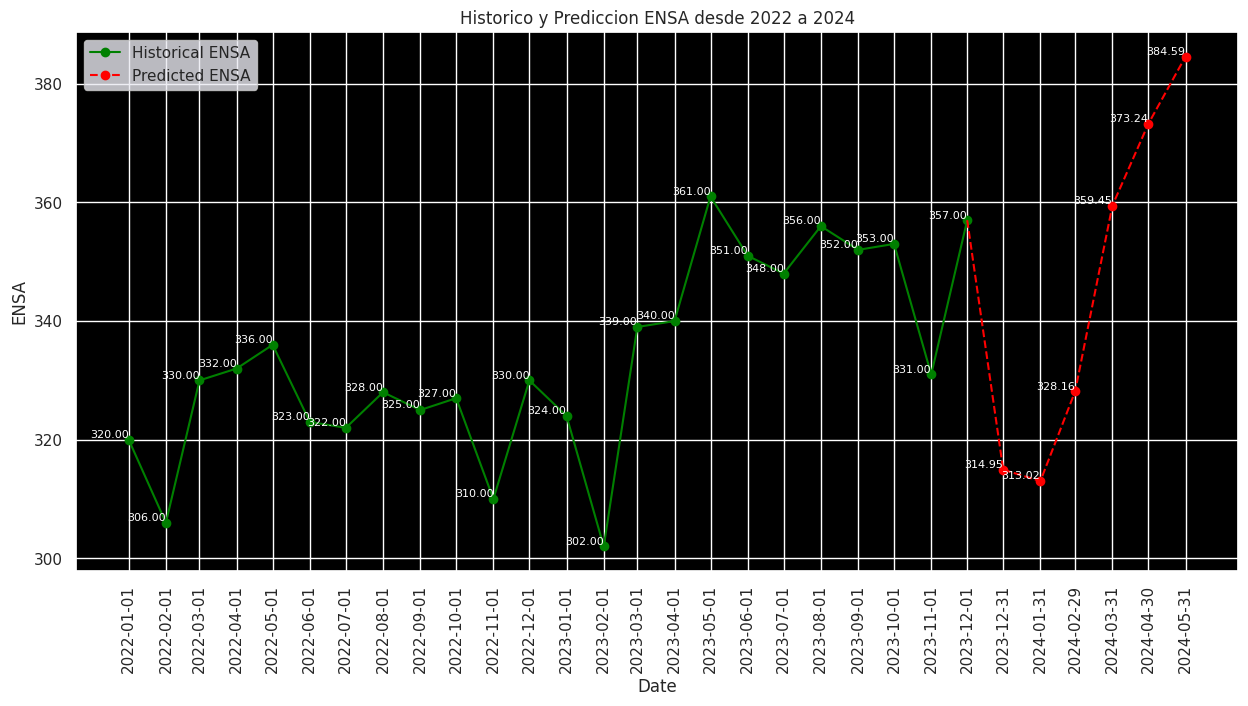

In [ ]:
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Graficar la serie histórica con puntos verdes y etiquetas de valores
historical = combined_data['ENSA'][:-periodos_pronostico]
plt.plot(combined_data['fecha'][:-periodos_pronostico], historical, label='Historical ENSA', color='green', marker='o')
for i, valor in enumerate(historical):
    plt.text(combined_data['fecha'].iloc[i], valor, f'{valor:.2f}', color='white', fontsize=8, ha='right', va='bottom')

# Graficar la serie pronosticada con puntos rojos y etiquetas de valores
predicted = combined_data['ENSA'].tail(periodos_pronostico)
plt.plot(combined_data['fecha'].tail(periodos_pronostico), predicted, label='Predicted ENSA', color='red', linestyle='--', marker='o')
for i, valor in enumerate(predicted):
    plt.text(combined_data['fecha'].iloc[-periodos_pronostico + i], valor, f'{valor:.2f}', color='white', fontsize=8, ha='right', va='bottom')

# Agregar línea que une los puntos verdes y rojos
plt.plot([combined_data['fecha'][:-periodos_pronostico].iloc[-1], combined_data['fecha'].tail(periodos_pronostico).iloc[0]],
         [combined_data['ENSA'][:-periodos_pronostico].iloc[-1], combined_data['ENSA'].tail(periodos_pronostico).iloc[0]],
         color='red',linestyle='--')

# Establecer el título y etiquetas de los ejes
plt.title('Historico y Prediccion ENSA desde 2022 a 2024')
plt.xlabel('Date')
plt.ylabel('ENSA')

# Rotar los títulos del eje x para que se vean todos
plt.xticks(rotation=90)

# Ajustar los ticks del eje x para mostrar más divisiones
plt.xticks(combined_data['fecha'], rotation=90)

# Mostrar la leyenda
plt.legend()

# Establecer el fondo negro y agregar cuadrícula
plt.gca().set_facecolor('black')
plt.grid(True, color='white')

# Mostrar la gráfica
plt.show()
